# Problem set #9
### by Alexander Tyan, March 12, 2018

## 1). 

In [192]:
import pandas as pd
import numpy as np
from sklearn.cross_validation import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import LeaveOneOut, KFold
from sklearn.linear_model import LogisticRegression
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np
# Import dataset as pandas df:
df = pd.read_csv("data/strongdrink.txt")

### a). Create a scatterplot of the data where the x-variable is alcohol (alco) and the y-variable is color intensity (color int). Make the dot of each of the three possible cultivar types a dierent color. Make sure your plot has a legend.

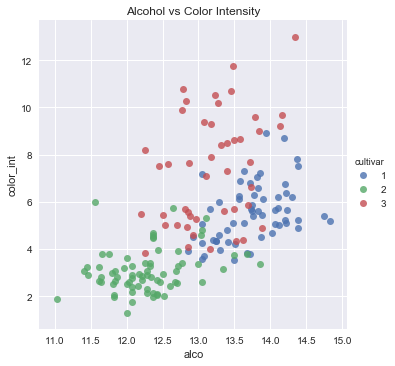

In [193]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.lmplot(x="alco", y="color_int", data=df, fit_reg=False, hue='cultivar', legend=True)
plt.title('Alcohol vs Color Intensity')
plt.show()

### b). Use sklearn.linear model.LogisticRegression to fit a multinomial logistic model of cultivar on features alcohol (alco), malic acid (malic), total phenols (tot phen), and color intensity (color int) with the following linear predictor.

In [194]:
# Dependent/independent variables:
X = df[["alco", "malic", "tot_phen", "color_int"]]
y = df[["cultivar"]]

In [195]:
# 75% sample training set:
X_train, X_test, y_train, y_test = \
train_test_split(X, y, test_size = 0.25, random_state=22)

In [196]:
# Train to fit a multinomial logistic regression:
MultLogReg = LogisticRegression(multi_class='multinomial',
                                solver='newton-cg',
                                penalty="l2",
                               C=1)
MultLogReg.fit(X_train, y_train)
# Predict response based on test indep. vars.:
y_pred = MultLogReg.predict(X_test)
print("Estimated Coefficients:")
print(MultLogReg.intercept_)
print(MultLogReg.coef_)
classification = classification_report(y_test, y_pred)
print(classification)

Estimated Coefficients:
[-23.17959572  23.46463201  -0.28503629]
[[ 1.56220083 -0.24119145  1.38349285  0.13566983]
 [-1.40220828 -0.35419071  0.37961117 -1.09904461]
 [-0.15999254  0.59538219 -1.763104    0.96337485]]
             precision    recall  f1-score   support

          1       0.86      0.92      0.89        13
          2       0.94      0.89      0.91        18
          3       1.00      1.00      1.00        13

avg / total       0.93      0.93      0.93        44



/Users/alexander/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### Use k-fold cross-validation to estimate the MSE of the multinomial logit model. Play with the tuning parameter values penalty and C to get the lowest possible k-fold MSE. Report your minimized overall MSE along with the tuning parameter values you used for penalty and C.

In [201]:
# Indicator function:
def indicator_2(y_test_array, y_pred_array):
    """
    Indicator function, returns 1 if the predicted
    value is the same as the test value, 0 otherwise.
    y_test_val: integer
    y_pred_val: integer
    return: integer, 0 or 1
    """
    array = (y_test_array == y_pred_array)
    return array.astype(int)

# Separate into dependent/indepndent vars Numpy arrays:
Xvars = df[["alco", "malic", "tot_phen", "color_int"]].values
yvals = df[["cultivar"]].values.ravel()

# Cross validation:
def mult_logit(xvars, yvals, c, penalty, print_out=True):
    k = 4
    clf_mlog = KFold(n_splits=k, shuffle=True, random_state=22)
    clf_mlog.get_n_splits(X)

    results_df_clf_mlog = pd.DataFrame(columns=["y_test", "y_pred", "MSE"])

    MSE_vec_clf_mlog = np.zeros(k)

    k_ind = int(0)
    for train_index, test_index in clf_mlog.split(Xvars):
        X_train, X_test = Xvars[train_index], Xvars[test_index]
        y_train, y_test = yvals[train_index], yvals[test_index]
        MultLogReg = LogisticRegression(multi_class='multinomial', 
                                        solver='newton-cg',
                                        penalty=penalty, C=c)
        MultLogReg.fit(X_train, y_train)
        y_pred = MultLogReg.predict(X_test)
        df1 = pd.DataFrame(y_test, columns=["y_test"])
        df2 = pd.DataFrame(y_pred, columns=["y_pred"])
        df_concat = pd.concat([df1, df2], axis=1)
        one_MSE = (1 - indicator_2(df_concat["y_test"], df_concat["y_pred"])) ** 2
        df_concat["MSE"] = one_MSE
        results_df_clf_mlog = results_df_clf_mlog.append(df_concat)
        MSE_vec_clf_mlog[k_ind] = one_MSE.mean()
        k_ind += 1

    # Enforce integer dtypes:
    results_df_clf_mlog[["y_test", "y_pred", "MSE"]] = results_df_clf_mlog[["y_test", "y_pred", "MSE"]].apply(pd.to_numeric)
    
    # Report MSE Results:
    MSE_clf_mlog = MSE_vec_clf_mlog.mean()
    MSE_clf_mlog_std = MSE_vec_clf_mlog.std()
    if print_out:
        print("NOTE: using newton-cg solver => only L2 penalty is availible")
        print("=================================================")
        print('test estimate MSE k-fold=', MSE_clf_mlog)
        print('test estimate MSE standard err=', MSE_clf_mlog_std)
        print('C =', c)
        print('penalty =', penalty)
        print("=================================================")
    return c, penalty, MSE_clf_mlog, MSE_clf_mlog_std

# Manual "play around":
mult_logit(Xvars, yvals, .1, "l2")
mult_logit(Xvars, yvals, .2, "l2")
mult_logit(Xvars, yvals, .3, "l2")
mult_logit(Xvars, yvals, .4, "l2")
mult_logit(Xvars, yvals, .5, "l2")
mult_logit(Xvars, yvals, .7, "l2")
mult_logit(Xvars, yvals, .8, "l2")
mult_logit(Xvars, yvals, 1, "l2")
mult_logit(Xvars, yvals, 5, "l2")
mult_logit(Xvars, yvals, 10, "l2")
mult_logit(Xvars, yvals, 100, "l2")
mult_logit(Xvars, yvals, 1000, "l2")


# More automated "play around":
def mult_logit_optimize(c_range_start, c_range_end):
    best_MSE = 1000
    bset_MSE_std = None
    best_c = None
    best_penalty = None
    for c in np.arange(c_range_start, c_range_end, 0.1):
        c, penalty, MSE_clf_mlog, MSE_clf_mlog_std = mult_logit(Xvars, yvals, c, "l2", False)
        if MSE_clf_mlog < best_MSE:
            best_MSE = MSE_clf_mlog
            bset_MSE_std = MSE_clf_mlog_std
            best_c = c
            best_penalty = penalty
    return best_MSE, bset_MSE_std, best_c, best_penalty
        
best_MSE, bset_MSE_std, best_c, best_penalty = mult_logit_optimize(0.1, 20)
print("=================================================")
print("MSE OPTIMIZATION RESULTS (NOTE: using newton-cg solver => only L2 penalty is availible):")
print("NOTE: using newton-cg solver => only L2 penalty is availible")
print('test estimate MSE k-fold=', best_MSE)
print('test estimate MSE standard err=', bset_MSE_std)
print('C =', best_c)
print('penalty =', best_penalty)
print("=================================================")

NOTE: using newton-cg solver => only L2 penalty is availible
test estimate MSE k-fold= 0.0909090909091
test estimate MSE standard err= 0.0321412173267
C = 0.1
penalty = l2
NOTE: using newton-cg solver => only L2 penalty is availible
test estimate MSE k-fold= 0.0795454545455
test estimate MSE standard err= 0.0254098633807
C = 0.2
penalty = l2
NOTE: using newton-cg solver => only L2 penalty is availible
test estimate MSE k-fold= 0.0681818181818
test estimate MSE standard err= 0.0278351107134
C = 0.3
penalty = l2
NOTE: using newton-cg solver => only L2 penalty is availible
test estimate MSE k-fold= 0.0681818181818
test estimate MSE standard err= 0.0278351107134
C = 0.4
penalty = l2
NOTE: using newton-cg solver => only L2 penalty is availible
test estimate MSE k-fold= 0.0738636363636
test estimate MSE standard err= 0.0247664712701
C = 0.5
penalty = l2
NOTE: using newton-cg solver => only L2 penalty is availible
test estimate MSE k-fold= 0.0852272727273
test estimate MSE standard err= 0.018

It looks like with C=.3 (and C=.4) and penalty L2, we get the lowest MSE = 0.0681818181818.

### c). Use sklearn.ensemble.RandomForestClassifier to t a random forest model of cultivar on the same four features used in part (b). set bootstrap=True, set oob score=True, and set random state=22. Use OOB cross-validation to generate the MSE of your random forest classier. Play with the values of the tuning parameters n estimators, max depth, and min samples leaf to try and nd the lowest possible MSE from the OOB cross validation. Report your minimized overall MSE along with the tuning parameter values you used for n estimators, max depth, and min samples leaf.

In [202]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

def rand_forest(n_estimators, max_depth, min_samples_leaf, print_out=True):
    rand_forest = RandomForestRegressor(n_estimators=n_estimators,
                                        max_depth=max_depth,
                                        min_samples_leaf=min_samples_leaf,
                                        max_features='sqrt', bootstrap=True,
                                        oob_score=True, random_state=22)
    rand_forest.fit(Xvars, yvals)

    rand_forest.score(Xvars, yvals)
    rand_forest_pred = rand_forest.oob_prediction_
    MSE_rand_forest = mean_squared_error(yvals, rand_forest_pred)
    if print_out:
        print("Num of estimators =", n_estimators)
        print("Max depth =", max_depth)
        print("Min samples in a leaf =", min_samples_leaf)
        print('MSE =', MSE_rand_forest)
        print("=============================================")
    return n_estimators, max_depth, min_samples_leaf, MSE_rand_forest

# Manual "play around":
rand_forest(53, 5, 5)
rand_forest(100, 5, 5)
rand_forest(1000, 5, 5)
rand_forest(53, 5, 5)
rand_forest(53, 10, 5)
rand_forest(53, 50, 5)
rand_forest(53, 10, 3)
rand_forest(53, 10, 10)
rand_forest(53, 10, 20)
rand_forest(1000, 10, 3)
rand_forest(1000, 5, 3)

Num of estimators = 53
Max depth = 5
Min samples in a leaf = 5
MSE = 0.126754651655
Num of estimators = 100
Max depth = 5
Min samples in a leaf = 5
MSE = 0.125630868435
Num of estimators = 1000
Max depth = 5
Min samples in a leaf = 5
MSE = 0.124780654982
Num of estimators = 53
Max depth = 5
Min samples in a leaf = 5
MSE = 0.126754651655
Num of estimators = 53
Max depth = 10
Min samples in a leaf = 5
MSE = 0.12683020618
Num of estimators = 53
Max depth = 50
Min samples in a leaf = 5
MSE = 0.12683020618
Num of estimators = 53
Max depth = 10
Min samples in a leaf = 3
MSE = 0.123611956237
Num of estimators = 53
Max depth = 10
Min samples in a leaf = 10
MSE = 0.132806645468
Num of estimators = 53
Max depth = 10
Min samples in a leaf = 20
MSE = 0.178892315018
Num of estimators = 1000
Max depth = 10
Min samples in a leaf = 3
MSE = 0.116086640331
Num of estimators = 1000
Max depth = 5
Min samples in a leaf = 3
MSE = 0.115935237276


(1000, 5, 3, 0.11593523727612604)

In [ ]:
# More automated "play around":
def rand_foreset_mse_optimize(n_estimators_min, n_estimators_max, 
                              max_depth_min, max_depth_max, 
                              min_samples_leaf_min, min_samples_leaf_max):
    best_mse = 1000
    best_num_estimators = None
    best_max_depth = None
    best_min_samples = None
    for num_estimators in range(n_estimators_min, n_estimators_max + 1):
        for max_depth in range(max_depth_min, max_depth_max + 1):
            for min_sample_num in range(min_samples_leaf_min, min_samples_leaf_max + 1):
                n_estimators, max_depth, min_samples_leaf, MSE_rand_forest = rand_forest(n_estimators=num_estimators, 
                                                                                         max_depth=max_depth, 
                                                                                         min_samples_leaf=min_sample_num, 
                                                                                         print_out=False)
                if MSE_rand_forest < best_mse:
                    best_mse = MSE_rand_forest
                    best_num_estimators = n_estimators
                    best_max_depth = max_depth
                    best_min_samples = min_samples_leaf
    return best_mse, best_num_estimators, best_max_depth, best_min_samples
        
best_mse, best_num_estimators, best_max_depth, best_min_samples = rand_foreset_mse_optimize(n_estimators_min=10, n_estimators_max=1000, 
                              max_depth_min=2, max_depth_max=10, 
                              min_samples_leaf_min=2, min_samples_leaf_max=10)

print("=============================================")
print("Automated Results:")
print("Num of estimators =", best_num_estimators)
print("Max depth =", best_max_depth)
print("Min samples in a leaf =", best_min_samples)
print('MSE =', best_mse)
print("=============================================")

The smallest MSE of 0.115935237276 is achieved with 1000 estimators (trees), max depth of 5 and minimum samples in a leaf of 3.

### d). Use sklearn.svm.SVC to fit a support vector machines model of cultivar with a Gaussian radial basis function kernel kernel='rbf' on the four features used in parts (b) and (c). Fit the model using k-fold cross validation with k = 4 folds exactly as in part (b). Play with the penalty parameter C and the coefficient on the radial basis function gamma to try and find the lowest possible MSE from the k-fold cross validation. Report your minimized overall MSE along with the tuning parameter values you used for C and gamma.

In [161]:
from sklearn import svm

def svc(gamma, c):
    k = 4
    clf_svm = KFold(n_splits=k, shuffle=True, random_state=22, print_out=True)
    clf_svm.get_n_splits(Xvars)

    MSE_vec_clf_svm = np.zeros(k)
    error_vec_cat_0 = np.zeros(k)
    error_vec_cat_1 = np.zeros(k)

    k_ind = int(0)

    for train_index, test_index in clf_svm.split(Xvars):
        X_train, X_test = Xvars[train_index], Xvars[test_index]
        y_train, y_test = yvals[train_index], yvals[test_index]

        svc_rbf = svm.SVC(kernel='rbf', gamma=gamma, C=c)
        svc_rbf.fit(X_train, y_train)
        y_pred_rbf = svc_rbf.predict(X_test)
        MSE_rbf = mean_squared_error(y_test, y_pred_rbf)
        MSE_vec_clf_svm[k_ind] = MSE_rbf

        k_ind += 1

    mean_SVC_MSE = MSE_vec_clf_svm.mean()
    SVC_MSE_std = MSE_vec_clf_svm.std()
    if print_out:
        print("Gamma =", gamma)
        print("C =", c)
        print("Mean MSE (SVC Model) = ", mean_SVC_MSE)
        print('Mean SE of MSE (SVC Model) =', SVC_MSE_std)
        print("================================================")
    return mean_SVC_MSE, SVC_MSE_std, gamma, c

# Manual "play around":
svc(.2, 1)
svc(.1, 1)
svc(.3, 1)
svc(.01, 1)
svc(.15, 1)
svc(.1, 10)
svc(.1, 100)
svc(.1, 50)
svc(.1, 20)
svc(.1, 15)
svc(.1, 12)
svc(.1, 9)
svc(.1, 8)

Gamma = 0.2
C = 1
Mean MSE (SVC Model) =  0.153409090909
Mean SE of MSE (SVC Model) = 0.0969245574388
Gamma = 0.1
C = 1
Mean MSE (SVC Model) =  0.147727272727
Mean SE of MSE (SVC Model) = 0.0997155044022
Gamma = 0.3
C = 1
Mean MSE (SVC Model) =  0.153409090909
Mean SE of MSE (SVC Model) = 0.10084226903
Gamma = 0.01
C = 1
Mean MSE (SVC Model) =  0.170454545455
Mean SE of MSE (SVC Model) = 0.0887528372262
Gamma = 0.15
C = 1
Mean MSE (SVC Model) =  0.153409090909
Mean SE of MSE (SVC Model) = 0.0969245574388
Gamma = 0.1
C = 10
Mean MSE (SVC Model) =  0.107954545455
Mean SE of MSE (SVC Model) = 0.0336140896767
Gamma = 0.1
C = 100
Mean MSE (SVC Model) =  0.147727272727
Mean SE of MSE (SVC Model) = 0.0340909090909
Gamma = 0.1
C = 50
Mean MSE (SVC Model) =  0.136363636364
Mean SE of MSE (SVC Model) = 0.0278351107134
Gamma = 0.1
C = 20
Mean MSE (SVC Model) =  0.125
Mean SE of MSE (SVC Model) = 0.0254098633807
Gamma = 0.1
C = 15
Mean MSE (SVC Model) =  0.125
Mean SE of MSE (SVC Model) = 0.025409

/Users/alexander/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


The lowest MSE of these trials is 0.107954545455 with Gamma = 0.1 and C = 10. Similar results can be achieve with Gamma = 0.1 and C = 9. (I did not do more automated MSE optimization due to computational intensity)

### e). Use sklearn.neural network.MLPClassifier to fit a single hidden layer neural network model of cultivar. Fit the model using k-fold cross validation with k = 4 folds exactly as in parts (b) and (d).

In [162]:
from sklearn.neural_network import MLPClassifier

def mlp(activation, alpha, hidden_layer_sizes):
    k = 4
    clf_mlp = KFold(n_splits=k, shuffle=True, random_state=22)
    clf_mlp.get_n_splits(Xvars)

    MSE_vec_clf_mlp = np.zeros(k)
    error_vec_cat_0 = np.zeros(k)
    error_vec_cat_1 = np.zeros(k)

    k_ind = int(0)

    for train_index, test_index in clf_mlp.split(Xvars):
        X_train, X_test = Xvars[train_index], Xvars[test_index]
        y_train, y_test = yvals[train_index], yvals[test_index]

        mlp = MLPClassifier(activation=activation, solver='lbfgs', alpha=alpha, 
                            hidden_layer_sizes=hidden_layer_sizes)
        mlp.fit(X_train, y_train)
        y_pred_mlp = mlp.predict(X_test)
        
        MSE_mlp = 1 - mlp.score(X_test, y_test) #mean_squared_error(y_test, y_pred_mlp)
        MSE_vec_clf_mlp[k_ind] = MSE_mlp

        k_ind += 1
    mean_mlp_MSE = MSE_vec_clf_mlp.mean()
    mlp_MSE_std = MSE_vec_clf_mlp.std()
    print("Activation function:", activation)
    print("Regularization penalty alpha =", alpha)
    print("Size of hidden layer:", hidden_layer_sizes)
    print("Mean MSE (MLP Model) =", mean_mlp_MSE)
    print('Mean SE of MSE (MLP Model)=', mlp_MSE_std)
    print("================================================")

mlp("tanh", 0.1, 98)
mlp("tanh", 0.1, 100)
mlp("tanh", 0.1, 150)
mlp("tanh", 0.1, 105)
mlp("tanh", 1, 100)
mlp("tanh", 0.2, 100)
mlp("logistic", 0.1, 100)
mlp("logistic", 0.1, 200)
mlp("logistic", 0.1, 300)
mlp("logistic", 0.01, 100)
mlp("relu", 0.1, 100)
mlp("relu", 0.1, 50)
mlp("relu", 0.1, 100)
mlp("relu", 0.1, 150)
mlp("relu", 0.2, 150)
mlp("relu", 0.09, 150)

/Users/alexander/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:912: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Activation function: tanh
Regularization penalty alpha = 0.1
Size of hidden layer: 98
Mean MSE (MLP Model) = 0.0511363636364
Mean SE of MSE (MLP Model)= 0.0295235933108
Activation function: tanh
Regularization penalty alpha = 0.1
Size of hidden layer: 100
Mean MSE (MLP Model) = 0.0681818181818
Mean SE of MSE (MLP Model)= 0.0278351107134
Activation function: tanh
Regularization penalty alpha = 0.1
Size of hidden layer: 150
Mean MSE (MLP Model) = 0.0681818181818
Mean SE of MSE (MLP Model)= 0.0278351107134
Activation function: tanh
Regularization penalty alpha = 0.1
Size of hidden layer: 105
Mean MSE (MLP Model) = 0.0511363636364
Mean SE of MSE (MLP Model)= 0.0336140896767
Activation function: tanh
Regularization penalty alpha = 1
Size of hidden layer: 100
Mean MSE (MLP Model) = 0.0681818181818
Mean SE of MSE (MLP Model)= 0.0278351107134
Activation function: tanh
Regularization penalty alpha = 0.2
Size of hidden layer: 100
Mean MSE (MLP Model) = 0.0625
Mean SE of MSE (MLP Model)= 0.029523

### d). Which of the above three models do you think is the best predictor of cultivar? Why?